In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
import torch
import torchvision
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import segmentation_models_pytorch as smp


device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
batch_size=1
img_size=512
tf = ToTensor()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [2]:
X_train, X_test, Y_train, Y_test=(['../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_300-600_00007166.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3000-3300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3000-3300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_300-600_00003523.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1200-1500 _5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_300-600_00009001.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_1.png'],
 ['../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1800-2100 1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_300-600_00007614.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1200-1500 _4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_900-1200_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_300-600_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_300-600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL18_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_900-1200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_600-900_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_600-900_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL15_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_0-300_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_300-600_00000149.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_300-600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_300-600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_300-600_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_600-900_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_0-300_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL19_0-300_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL2_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL16_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL9_900-1200_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL5_0-300_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_900-1200_1.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL11_600-900_3.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL14_600-900_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_2.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL4_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL10_0-300_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_4.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL20_900-1200_5.png',
  '../../data/img/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_3.png'],
 ['../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_300-600_00007166.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3000-3300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3000-3300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5400-5700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_300-600_00003523.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1200-1500 _5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_300-600_00009001.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6600-6900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4500-4800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4800-5100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5100-5400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3600-3900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_4500-4800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4800-5100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4200-4500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_5400-5700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5700-6000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3600-3900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3600-3900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3900-4200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3600-3900_1.png'],
 ['../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_3000-3300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1800-2100 1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1500-1800 _3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4500-4800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_300-600_00007614.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3900-4200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_3000-3300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1200-1500 _4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3000-3300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3900-4200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_900-1200_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4800-5100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3000-3300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5400-5700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_4500-4800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_3600-3900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3000-3300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2700-3000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3900-4200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2400-2700_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_300-600_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4200-4500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1200-1500_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1500-1800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2100-2400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_6000-6300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4500-4800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_4500-4800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_300-600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3000-3300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL18_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_1200-1500_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_4500-4800_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL17_2700-3000_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_900-1200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_4800-5100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3000-3300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_2400-2700_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3600-3900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3600-3900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1800-2100_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_4200-4500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_600-900_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_2100-2400 _4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_4200-4500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_1800-2100_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL1_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_600-900_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL15_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_1800-2100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_0-300_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1500-1800_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_1200-1500_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2100-2400_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_300-600_00000149.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_3600-3900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3300-3600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL7_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_300-600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_300-600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_1800-2100_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_300-600_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3300-3600_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL12_2100-2400_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_5700-6000_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_600-900_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_5100-5400_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_2400-2700_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_0-300_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_1200-1500_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_2700-3000_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_2400-2700_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_3900-4200_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL19_0-300_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL2_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_3900-4200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL16_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL9_900-1200_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL5_0-300_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_4800-5100_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_900-1200_1.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1500-1800_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL8_1800-2100_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL11_600-900_3.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL14_600-900_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL13_3300-3600_2.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL4_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL21_3300-3600_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL10_0-300_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL6_1200-1500_4.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL20_900-1200_5.png',
  '../../data/mask/GGHB_DC68_LSH0_ENME_GIL3_3300-3600_3.png'])

In [3]:


test_image=torch.zeros((len(X_test),3,img_size,img_size))
test_mask=torch.zeros((len(Y_test),4,img_size,img_size),dtype=torch.uint8)    
train_image=torch.zeros((len(X_train),3,img_size,img_size))
train_mask=torch.zeros((len(Y_train),4,img_size,img_size),dtype=torch.uint8)

for i in tqdm(range(len(X_train))):
    train_image[i] = tf(np.array(Image.open(X_train[i]).resize((img_size, img_size))))
    temp_mask=np.array(Image.open(Y_train[i]).convert('L').resize((img_size, img_size)))
    train_mask[i,1]=tf(np.where(temp_mask==1,1,0))
    train_mask[i,2]=tf(np.where(temp_mask==2,1,0))
    train_mask[i,3]=tf(np.where(temp_mask==3,1,0))
    train_mask[i, 0] = torch.where(
        (train_mask[i, 1]+train_mask[i, 2]+train_mask[i, 3]) == 0, 1, 0)

for i in tqdm(range(len(X_test))):
    test_image[i] = tf(np.array(Image.open(X_test[i]).resize((img_size, img_size))))
    temp_mask=np.array(Image.open(Y_test[i]).convert('L').resize((img_size, img_size)))
    test_mask[i,1]=tf(np.where(temp_mask==1,1,0))
    test_mask[i,2]=tf(np.where(temp_mask==2,1,0))
    test_mask[i,3]=tf(np.where(temp_mask==3,1,0))
    test_mask[i, 0] = torch.where(
        (test_mask[i, 1]+test_mask[i, 2]+test_mask[i, 3]) == 0, 1, 0)


100%|██████████| 218/218 [00:15<00:00, 14.04it/s]


In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path = self.img_path[idx]
        label_path =  self.label[idx]
        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

test_dataset = CustomDataset(test_image, test_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
model=smp.UnetPlusPlus('efficientnet-b5', in_channels=3, classes=4).to(device)
summary(model,(batch_size,3,img_size,img_size))
def dice_loss(pred, target, num_classes=4):
    # Apply softmax to predictions
    pred_softmax = F.softmax(pred, dim=1)
    
    # Ensure the target tensor is in float type
    target = target.float()
    dice_loss=torch.zeros(len(target),num_classes)
    for i in range(len(target)):
        # Calculate the Dice coefficient for each class
        intersection = (pred_softmax[i] * target[i]).sum(dim=(1, 2))
        union = pred_softmax[i].sum(dim=(1,2)) + target[i].sum(dim=(1,2))
        
        dice_coefficient = 2. * intersection / (union + 1e-5)  # Adding a small epsilon to avoid division by zero
        
        # Calculate the Dice loss
        dice_loss[i] = 1 - dice_coefficient
        if target[i].sum()==0:
            dice_loss[i]=2
    return dice_loss


model.load_state_dict(torch.load('../../model/UnetPlusPlus_callback.pt'))

<All keys matched successfully>

 Step: 11 :   4%|▎         | 8/218 [00:00<00:06, 31.31it/s]

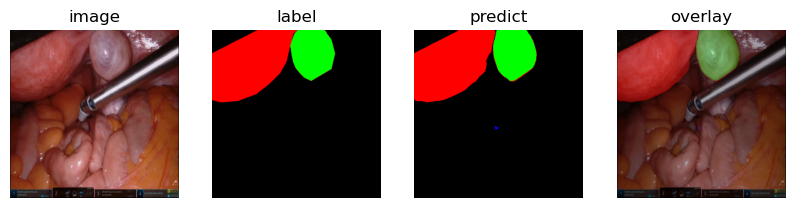

 Step: 21 :   7%|▋         | 16/218 [00:01<00:12, 16.80it/s]

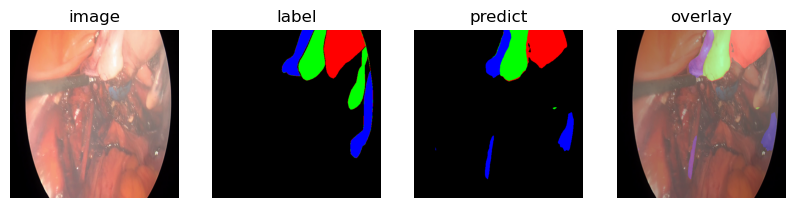

 Step: 31 :  13%|█▎        | 28/218 [00:01<00:09, 20.25it/s]

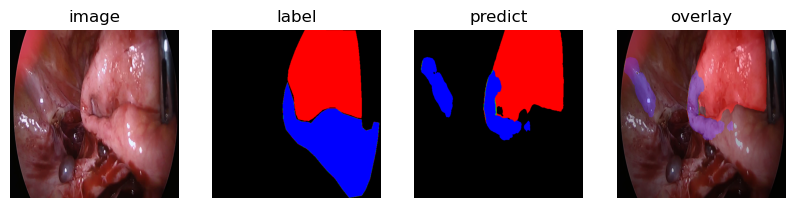

 Step: 41 :  18%|█▊        | 39/218 [00:02<00:08, 21.59it/s]

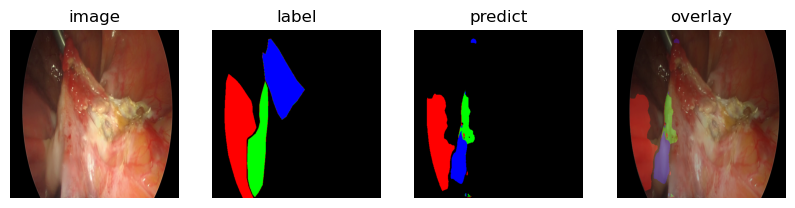

 Step: 51 :  21%|██        | 46/218 [00:02<00:08, 19.18it/s]

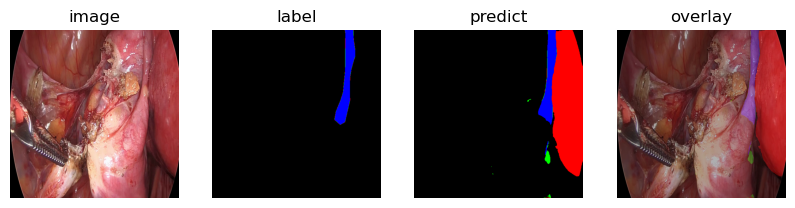

 Step: 61 :  27%|██▋       | 58/218 [00:03<00:07, 21.25it/s]

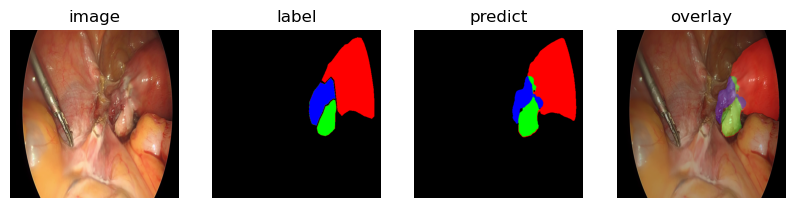

 Step: 71 :  32%|███▏      | 69/218 [00:03<00:06, 22.23it/s]

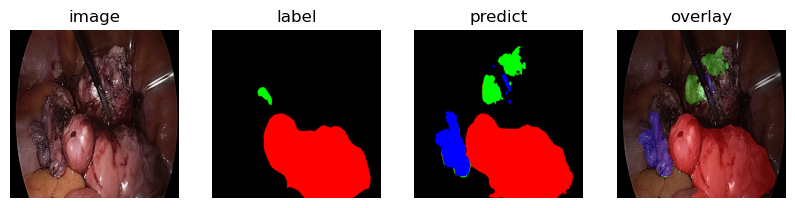

 Step: 81 :  35%|███▍      | 76/218 [00:04<00:07, 19.00it/s]

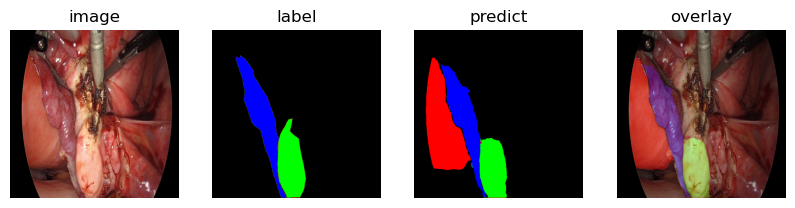

 Step: 91 :  40%|████      | 88/218 [00:04<00:06, 21.29it/s]

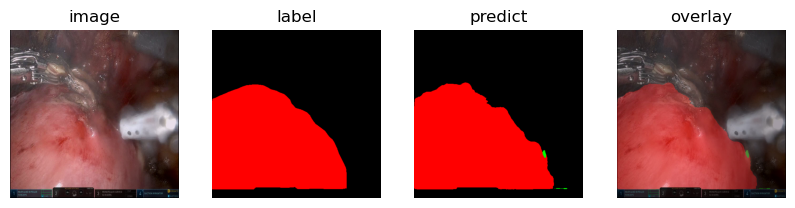

 Step: 101 :  45%|████▌     | 99/218 [00:05<00:05, 21.60it/s]

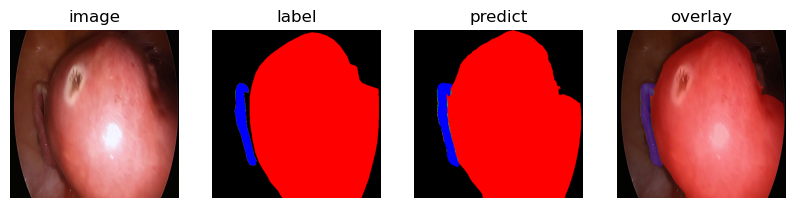

 Step: 111 :  49%|████▊     | 106/218 [00:06<00:05, 18.91it/s]

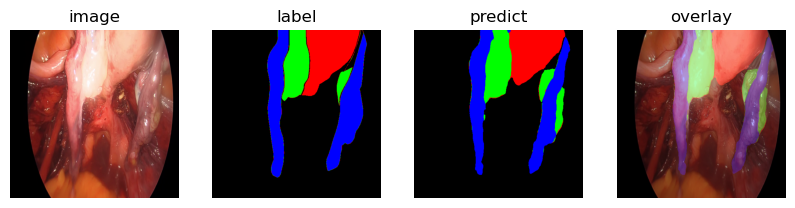

 Step: 121 :  54%|█████▍    | 118/218 [00:06<00:05, 18.88it/s]

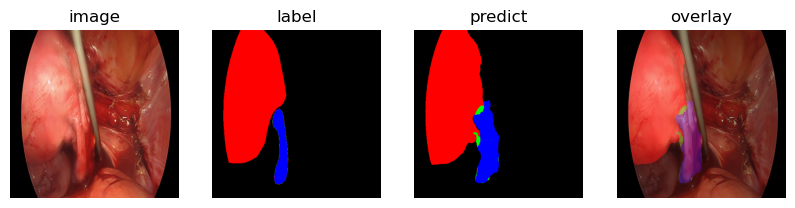

 Step: 131 :  59%|█████▉    | 129/218 [00:07<00:04, 20.98it/s]

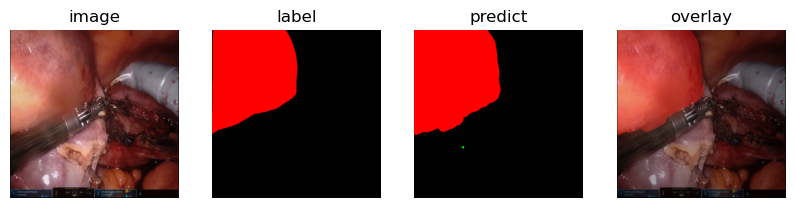

 Step: 141 :  62%|██████▏   | 136/218 [00:07<00:04, 18.68it/s]

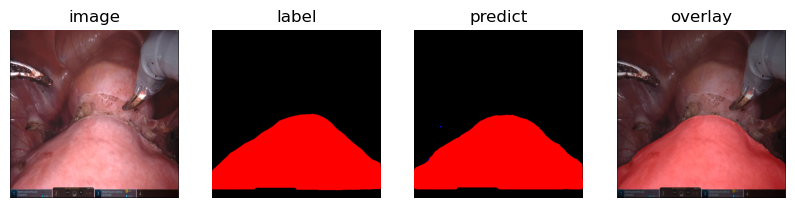

 Step: 151 :  68%|██████▊   | 148/218 [00:08<00:03, 21.07it/s]

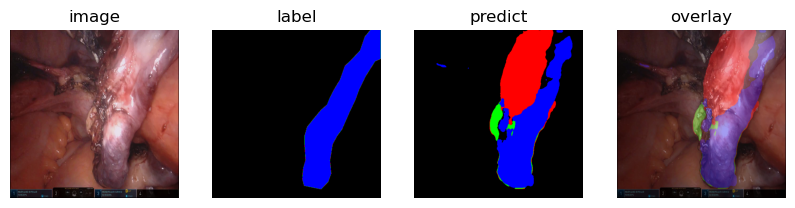

 Step: 161 :  73%|███████▎  | 159/218 [00:09<00:02, 21.70it/s]

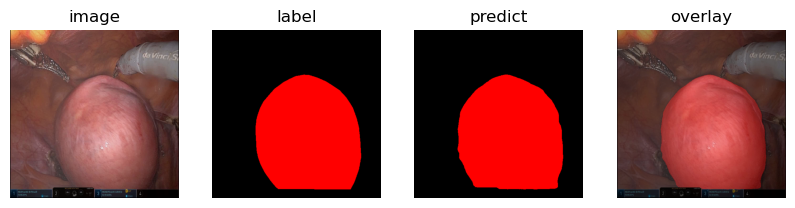

 Step: 171 :  76%|███████▌  | 166/218 [00:09<00:02, 19.02it/s]

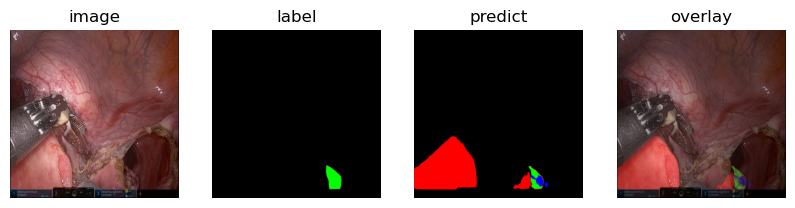

 Step: 181 :  82%|████████▏ | 178/218 [00:10<00:01, 21.27it/s]

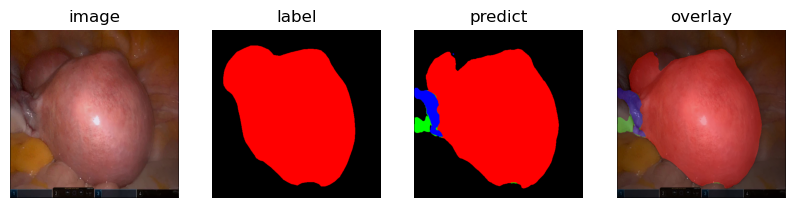

 Step: 191 :  87%|████████▋ | 189/218 [00:10<00:01, 21.68it/s]

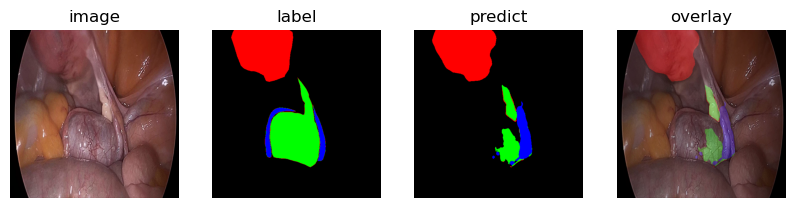

 Step: 201 :  90%|████████▉ | 196/218 [00:11<00:01, 18.58it/s]

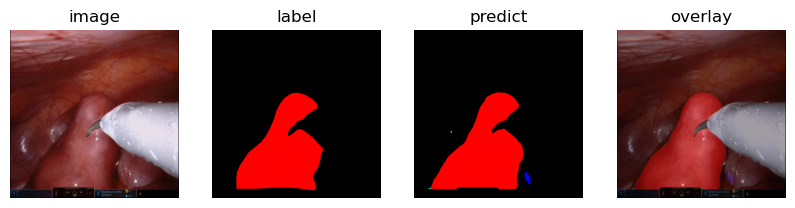

 Step: 211 :  95%|█████████▌| 208/218 [00:11<00:00, 20.96it/s]

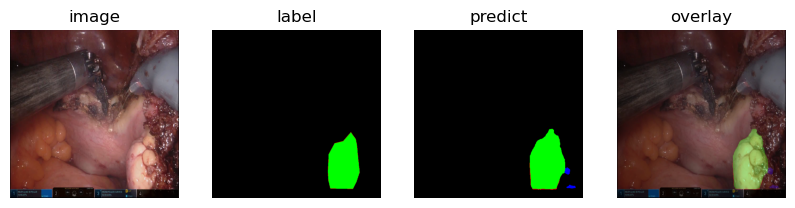

 Step: 219 : 100%|██████████| 218/218 [00:12<00:00, 17.40it/s]

batch size= 4
image size= 224
learning rate= 0.0001


In [9]:
topilimage = torchvision.transforms.ToPILImage()

train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
val=tqdm(test_dataloader)
model.eval()
count=0
val_running_loss=0.0
acc_loss=0
with torch.no_grad():
    for x, y in val:
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        predict = model(x).to(device)
        cost = dice_loss(predict, y).cpu().numpy()
        y = y.to('cpu')
        x=x.to('cpu')
        val.set_description(f" Step: {count+1} ")
        val_loss_list.append(1-cost)
        if count%10==0:
            pred_softmax = F.softmax(predict, dim=1)
            mask=torch.zeros((3,img_size,img_size))
            mask[0]=torch.where(pred_softmax.argmax(dim=1)==1,1,0)
            mask[1]=torch.where(pred_softmax.argmax(dim=1)==2,1,0)
            mask[2]=torch.where(pred_softmax.argmax(dim=1)==3,1,0)
            img=topilimage(x[0])
            label=topilimage(y[0][1:])
            mask=topilimage(mask)
            overlay=np.array(img)*0.7+np.array(mask)*0.3
            overlay=Image.fromarray(overlay.astype('uint8'))
            fig = plt.figure(figsize=(10,30))
            rows = 1
            cols = 4
            ax1 = fig.add_subplot(rows, cols, 1)
            ax1.imshow(img)
            ax1.set_title('image')
            ax1.axis("off")
            
            ax2 = fig.add_subplot(rows, cols, 2)
            ax2.imshow(label)
            ax2.set_title('label')
            ax2.axis("off")
            
            ax3 = fig.add_subplot(rows, cols, 3)
            ax3.imshow(mask)
            ax3.set_title('predict')
            ax3.axis("off")
            
            ax4 = fig.add_subplot(rows, cols, 4)
            ax4.imshow(overlay)
            ax4.set_title('overlay')
            ax4.axis("off")
            plt.show()
           

print('batch size= 4')
print('image size= 224')
print('learning rate= 0.0001')

In [10]:
dice_score=np.array(val_loss_list)[:,0,1:]
except_dice_index=np.where(dice_score!=2)
index1=np.where(except_dice_index[1]==0)
print(f'1 Class DSC={dice_score[except_dice_index[0][index1[0]],except_dice_index[1][index1[0]]].mean()}')
index2=np.where(except_dice_index[1]==1)
print(f'2 Class DSC={dice_score[except_dice_index[0][index2[0]],except_dice_index[1][index2[0]]].mean()}')
index3=np.where(except_dice_index[1]==2)
print(f'3 Class DSC={dice_score[except_dice_index[0][index3[0]],except_dice_index[1][index3[0]]].mean()}')

1 Class DSC=0.6596973538398743
2 Class DSC=0.3544228672981262
3 Class DSC=0.21980944275856018
